### Resnet from Scratch

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

2025-05-01 01:52:46.248969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746051766.265480   20292 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746051766.270482   20292 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746051766.282380   20292 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746051766.282397   20292 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746051766.282399   20292 computation_placer.cc:177] computation placer alr

### Resnet50 

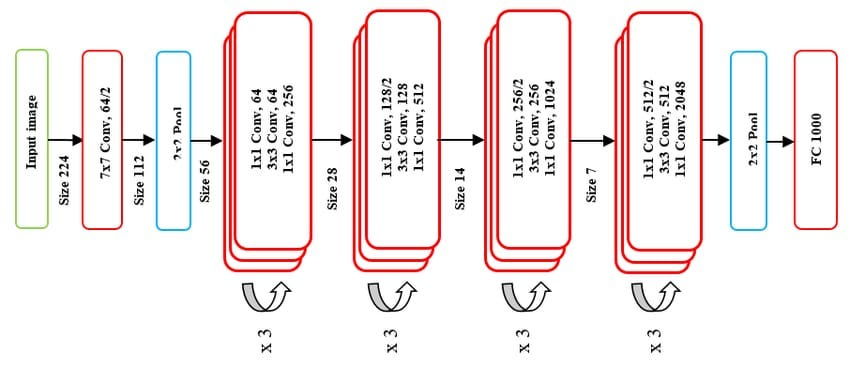

##### Identity Block
###### x : input tensor
###### filters      : list/tuple of ints [f1, f2, f3]
###### kernel_size  : int, the kernel size of the middle conv layer
###### Returns: Output tensor for the block. 

In [2]:
def identity_block(x, filters, kernel_size=3):
    f1, f2, f3 = filters
    shortcut = x
    
    x = layers.Conv2D(f1, (1,1), strides=(1,1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(f2, (kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(f3, (1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    
    # shortcut & ReLU
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

x            : input tensor

filters      : list/tuple of ints [f1, f2, f3]

kernel_size  : int, the kernel size of the middle conv layer

strides      : tuple, strides for the first conv and the shortcut conv

Returns      : Output tensor for the block.

In [3]:
def conv_block(x, filters, kernel_size=3, strides=(2,2)):
    f1, f2, f3 = filters

    shortcut = layers.Conv2D(f3, (1,1), strides=strides, padding='valid')(x)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(f1, (1, 1), strides=strides, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(f2, (kernel_size, kernel_size), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(f3, (1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


x -- input tensor

filters -- tuple of integers, the filters of 3 conv layers

stride -- default 1, stride for the first conv layer

downsample -- Boolean, whether to apply convolution to the shortcut path

Returns:  Output tensor for the block.

In [4]:
def bottleneck_block(x, filters, stride=1, downsample=False):
    f1, f2, f3 = filters
    shortcut = x

    x = layers.Conv2D(f1, (1, 1), strides=stride, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f2, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(f3, (1, 1), strides=1, padding='valid')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        shortcut = layers.Conv2D(f3, (1, 1), strides=stride, padding='valid')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


In [6]:
def ResNet50(input_shape=(224, 224, 3), num_classes=1000):
    """
    Constructs the ResNet-50 architecture.
    
    Parameters:
    input_shape -- shape of the input images
    num_classes -- number of output classes
    
    Returns:
    A Keras Model instance.
    """
    inputs = Input(shape=input_shape)
    x = layers.ZeroPadding2D((3, 3))(inputs)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # Stage 1
    x = bottleneck_block(x, [64, 64, 256], downsample=True)
    x = bottleneck_block(x, [64, 64, 256])
    x = bottleneck_block(x, [64, 64, 256])

    # Stage 2
    x = bottleneck_block(x, [128, 128, 512], stride=2, downsample=True)
    x = bottleneck_block(x, [128, 128, 512])
    x = bottleneck_block(x, [128, 128, 512])
    x = bottleneck_block(x, [128, 128, 512])

    # Stage 3
    x = bottleneck_block(x, [256, 256, 1024], stride=2, downsample=True)
    x = bottleneck_block(x, [256, 256, 1024])
    x = bottleneck_block(x, [256, 256, 1024])
    x = bottleneck_block(x, [256, 256, 1024])
    x = bottleneck_block(x, [256, 256, 1024])
    x = bottleneck_block(x, [256, 256, 1024])

    # Stage 4
    x = bottleneck_block(x, [512, 512, 2048], stride=2, downsample=True)
    x = bottleneck_block(x, [512, 512, 2048])
    x = bottleneck_block(x, [512, 512, 2048])

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [7]:
model = ResNet50(input_shape=(224, 224, 3), num_classes=1000)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1746051801.888921   20292 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2742 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)